In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from typing import Tuple
import matplotlib as mpl


from ndgsp.graph.graphs import Graph
from ndgsp.graph.filters import MultivariateFilterFunction

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

import sys
sys.path.append('..')

import scipy as sp
import os
import subprocess

from PIL import Image
from scipy.sparse.linalg import LinearOperator, cg
from tqdm.notebook import tqdm
import time

%matplotlib ipympl

Using Jax backend with device gpu:0


In [3]:
def vec(X: np.ndarray) -> np.ndarray:
    return X.T.reshape(-1)


def mat(x: np.ndarray, shape: tuple) -> np.ndarray:
    return x.reshape((shape[1], shape[0])).T


def path_graph(N: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get the adjacency matrix and Laplacian for a path graph

    Params:
        N       The number of nodes

    Returns:
        A       (N, N) adjacency matrix        
        L       (N, N) Laplacian matrix
    """

    A = np.zeros((N, N))
    A[range(N-1), range(1, N)] = 1
    A += A.T

    L = np.diag(A.sum(0)) - A

    return A, L


def g(lamN: float | np.ndarray, 
      lamT: float | np.ndarray, 
      betaN: float, 
      betaT: float) -> float | np.ndarray:
    """
    An example anisotropic diffusion graph filter function 

    Params:
        lamN                space eigenvalue
        lamT                time eigenvalue
        betaN               space filter parameter
        betaT               time filter parameter 

    Returns:
        g(λn, λt, βn, βt)   filter applied to eigenvalues
    """
    return np.exp(-(betaN * lamN + betaT * lamT))


def dummy_data(N: int, T: int, m: float, seed: int=0):
    """
    Generate some fake data for testing purposes with size (N, T) and
    missingness fraction 0 < m < 1
    """
    
    np.random.seed(seed)
    Y = np.random.normal(size=(N, T))
    S = np.ones(N * T, dtype=bool)
    S[np.random.choice(N * T, int(N * T * m), replace=False)] = False
    S = S.reshape((N, T))
    Y[S] = 0
    
    _, LN = path_graph(N)
    _, LT = path_graph(T)

    return Y, S, LN, LT




In [4]:
def idct(Y: np.ndarray) -> np.ndarray:
    """
    Apply IDCT matrix U to matrix of column vectors Y
    """
    return sp.fft.idct(Y.T, type=2, norm='ortho').T

def dct(Y: np.ndarray) -> np.ndarray:
    """
    Apply DCT matrix U.T to matrix of column vectors Y
    """
    return sp.fft.dct(Y.T, type=2, norm='ortho').T

def ridct(Y: np.ndarray) -> np.ndarray:
    """
    Apply matrix of row vectors Y to IDCT matrix U
    """
    return sp.fft.dct(Y, type=2, norm='ortho')

def rdct(Y: np.ndarray) -> np.ndarray:
    """
    Apply matrix of row vectors Y to DCT matrix U.T
    """
    return sp.fft.idct(Y, type=2, norm='ortho')


In [5]:
# edit this to set the maximum number of iterations
MAX_ITERS = 1e7


def direct(Y: np.ndarray, 
           S: np.ndarray, 
           LN: np.ndarray, 
           LT: np.ndarray, 
           gamma: float, 
           g: Callable, 
           decomposed_Ls: dict=None) -> np.ndarray:
    
    """
    Compute the posterior mean using direct Gaussian elimination
    """

   
    if decomposed_Ls is None:

        # decompose the graph Laplacians
        lamN, UN = np.linalg.eigh(LN)
        lamT, UT = np.linalg.eigh(LT)

    else:

        lamN, UN = decomposed_Ls['lamN'], decomposed_Ls['UN']
        lamT, UT = decomposed_Ls['lamT'], decomposed_Ls['UT']


    # compute the coefficient matrix directly using np.kron
    Hi2 = np.kron(UT, UN) @ np.diag(vec(g(lamN[:, None], lamT[None, :]) ** -2)) @ np.kron(UT.T, UN.T)

    # solve the linear system
    return mat(np.linalg.solve(gamma * Hi2 + np.diag(vec(S)), vec(Y)), Y.shape)


def SIM(Y: np.ndarray, 
        S: np.ndarray, 
        LN: np.ndarray, 
        LT: np.ndarray, 
        gamma: float, 
        g: Callable, 
        decomposed_Ls: dict=None) -> Tuple[np.ndarray, int]:
    
    """
    Perform the Stationary Iterative Method for computing the posterior mean

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        LT          (T, T) time-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    N, T = Y.shape

    if decomposed_Ls is None:

        lamN, UN = np.linalg.eigh(LN)
        lamT, UT = np.linalg.eigh(LT)

    else:

        lamN, UN = decomposed_Ls['lamN'], decomposed_Ls['UN']
        lamT, UT = decomposed_Ls['lamT'], decomposed_Ls['UT']

    G2 = g(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    S_ = 1 - S

    dF = UN @ (J * (UN.T @ Y @ UT)) @ UT.T

    F = dF

    nits = 0

    while (dF ** 2).sum() ** 0.5 / (N * T) > 1e-8:

        dF = UN @ (J * (UN.T @ (S_ * dF) @ UT)) @ UT.T

        F += dF

        nits += 1

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return F, nits


def SIM_grid(Y: np.ndarray, 
             S: np.ndarray, 
             gamma: float, 
             g: Callable) -> Tuple[np.ndarray, int]:
    
    """
    Perform the Stationary Iterative Method for computing the posterior mean, where 
    both the time-like and space-like graphs are a path graph, meaning we have 2D 
    grid data. Use the DCT to speed up where possible. 

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    N, T = Y.shape

    lamN = 2 - 2 * np.cos(N ** -1 * np.pi * np.arange(N))
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    G2 = g(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    S_ = 1 - S

    dF = rdct(idct((J * dct(ridct(Y)))))

    F = dF

    nits = 0

    while (dF ** 2).sum() ** 0.5 / (N * T) > 1e-8:

        dF = rdct(idct((J * dct(ridct(S_ * dF)))))

        F += dF

        nits += 1

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return F, nits


def CGM(Y: np.ndarray, 
         S: np.ndarray, 
         LN: np.ndarray, 
         LT: np.ndarray, 
         gamma: float, 
         g: Callable, 
         decomposed_Ls: dict=None) -> Tuple[np.ndarray, int]:
    """
    Perform the Conjugate Gradient Method for computing the posterior mean

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        LT          (T, T) time-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """
    
    N, T = Y.shape

    if decomposed_Ls is None:

        # decompose the graph Laplacians
        lamN, UN = np.linalg.eigh(LN)
        lamT, UT = np.linalg.eigh(LT)

    else:

        lamN, UN = decomposed_Ls['lamN'], decomposed_Ls['UN']
        lamT, UT = decomposed_Ls['lamT'], decomposed_Ls['UT']


    G = g(lamN[:, None], lamT[None, :])

    def matvec(z):

        Z = mat(z, (N, T))

        out = gamma * Z + G * (UN.T @ (S * (UN @ (G * Z) @ UT.T)) @ UT)

        return vec(out)
    
    nits = 0

    def iter_count(arr):
        nonlocal nits
        nits += 1
    
    linop = LinearOperator((N * T, N * T), matvec=matvec)
    
    z, exit_code = cg(linop, vec(G * (UN.T @ Y @ UT)), callback=iter_count, maxiter=MAX_ITERS)

    return UN @ (G * mat(z, (N, T))) @ UT.T, nits
 

def CGM_grid(Y: np.ndarray, 
              S: np.ndarray, 
              gamma: float, 
              g: Callable) -> Tuple[np.ndarray, int]:
        
    """
    Perform the Conjugate GRadient Method for computing the posterior mean, where 
    both the time-like and space-like graphs are a path graph, meaning we have 2D 
    grid data. Use the DCT to speed up where possible. 

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    N, T = Y.shape

    lamN = 2 - 2 * np.cos(N ** -1 * np.pi * np.arange(N))
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    G = g(lamN[:, None], lamT[None, :])

    def matvec(z):

        Z = mat(z, (N, T))

        out = gamma * Z + G * dct(ridct(S * idct(rdct(G * Z))))

        return vec(out)
    
    nits = 0

    def iter_count(arr):
        nonlocal nits
        nits += 1
    
    linop = LinearOperator((N * T, N * T), matvec=matvec)
    
    z, exit_code = cg(linop, vec(G * ridct(dct(Y))), callback=iter_count, maxiter=MAX_ITERS)

    return idct(rdct(G * mat(z, (N, T)))), nits


In [6]:
def verify_SIM_CGM():
    """
    Verify that the SIM and CGM give the correct answer to the linear system
    """

    np.random.seed(0)

    # beta should be relatively small so the matrix H is invertible
    betaN = 0.5
    betaT = 0.5
    gamma = 1

    # dimensions should be relatively small so the matrix H is invertible
    N = 10
    T = 12

    # fraction missingness
    m = 0.5

    # generate some data
    Y, S, LN, LT = dummy_data(N, T, m)
    g_ = lambda lamN, lamT: g(lamN, lamT, betaN, betaT)

    # calculate the solution directly 
    F_dir = direct(Y, S, LN, LT, gamma, g_)

    # calculate the solution using the SIM 
    F_sim1, _ = SIM(Y, S, LN, LT, gamma, g_)
    F_sim2, _ = SIM_grid(Y, S, gamma, g_)

    # calculate the solution using the CGM
    F_cgm1, _ = CGM(Y, S, LN, LT, gamma, g_)
    F_cgm2, _ = CGM_grid(Y, S, gamma, g_)

    for F_ in [F_sim1, F_sim2, F_cgm1, F_cgm2]:
        assert np.allclose(F_dir, F_, rtol=1e-4, atol=1e-4), f'{F_dir}, {Y_}'

    return True




In [7]:
verify_SIM_CGM()

True

In [7]:
def butterflies_plot():
    """
    Create the butterflies plot
    """

    np.random.seed(0)

    def get_Y_and_S_uniform(Y_true, SNR=0, p=0.5, seed=0):
        """
        Given a true underlying image, add noise with a given SNR and remove pixels 
        uniformly at random with probability p
        """

        np.random.seed(seed)
        
        sig_y = 10 ** (-SNR / 20)
        Y = Y_true + sig_y * np.random.randn(*Y_true.shape)
        S = np.random.choice(2, size=Y_true.shape, p=[1-p, p]).astype(bool)
        
        Y[S] = 0
        Y_nan = Y.copy()
        Y_nan[S] = np.nan
        
        return Y_nan, Y, S


    def get_Y_and_S_rowcol(Y_true, SNR=0, p=0.5, seed=1):
        """
        Given a true underlying image, add noise with a given SNR and remove columns
        and rows of pixels a random such that a total of p% of the pixels are removed
        """
            
        np.random.seed(seed)

        N, T = Y_true.shape

        sig_y = 10 ** (-SNR / 20)
        Y = Y_true + sig_y * np.random.randn(*Y_true.shape)
        
        S = np.ones(Y_true.shape, dtype=bool)
        S[np.random.choice(range(N), size= int(N * (1 - (1-p) ** 0.5)), replace=False), :] = False
        S[:, np.random.choice(range(T), size= int(T * (1 - (1-p) ** 0.5)), replace=False)] = False
            
        Y[~S] = 0
        Y_nan = Y.copy()
        Y_nan[~S] = np.nan
        
        return Y_nan, Y, S
    

    def plot_uniform_pixels(Y_true: np.ndarray):
        """
        Create a plot showing the reconstruction process over a range of noise
        and missingness levels for uniformly removed pixels
        """

        fig1, axes1 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))
        fig2, axes2 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))

        for i, snr in enumerate([10, 0, -10]):
            
            for j, p in enumerate([0.01, 0.1, 0.25, 0.5]):
                
                gamma = [1, 0.85, 0.75, 0.2][j]
            
                Y_nan, Y, S = get_Y_and_S_uniform(Y_true, SNR=snr, p=p)
                
                F, _ =  CGM_grid(Y, S, gamma, lambda lamN, lamT: g(lamN, lamT, 2, 2))
                
                axes1[i, j].imshow(Y_nan,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')
                axes2[i, j].imshow(F,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

                for ax in [axes1[i, j], axes2[i, j]]:
                    
                    ax.set_xticks([])
                    ax.set_yticks([])
                
        for ax, title in zip(axes1[0, :], ['$p=0.01$', '$p=0.1$', '$p=0.25$', '$p=0.5$']):
            ax.set_title(title, size='xx-large', )

        for ax, title in zip(axes1[:, 0], [r'SNR = 10 dB', 'SNR = 0 dB', 'SNR = -10 dB']):
            ax.set_ylabel(title,  size='x-large', labelpad=5)

        for ax, title in zip(axes2[:, 0], [r'SNR = 10 dB', 'SNR = 0 dB', 'SNR = -10 dB']):
            ax.set_ylabel(title,  size='x-large', labelpad=5)
            
        fig1.tight_layout()
        fig2.tight_layout()

        return fig1, fig2
    

    def plot_rowcol_pixels(Y_true: np.ndarray):
        """
        Create a plot showing the reconstruction process over a range of noise
        and missingness levels for entire columns and rows of pixels removed
        """

        fig1, axes1 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))
        fig2, axes2 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))

        for i, snr in enumerate([10, 0, -10]):
            
            for j, p in enumerate([0.01, 0.1, 0.25, 0.5]):
                
                gamma = [0.2, 0.2, 0.2, 0.1][j]
            
                Y_nan, Y, S = get_Y_and_S_rowcol(Y_true, SNR=snr, p=p)
                
                F, _ =  CGM_grid(Y, S, gamma, lambda lamN, lamT: g(lamN, lamT, 2, 2))
                
                axes1[i, j].imshow(Y_nan,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')
                axes2[i, j].imshow(F,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

                for ax in [axes1[i, j], axes2[i, j]]:
                    
                    ax.set_xticks([])
                    ax.set_yticks([])
                
        for ax, title in zip(axes1[0, :], ['$p=0.01$', '$p=0.1$', '$p=0.25$', '$p=0.5$']):
            ax.set_title(title, size='xx-large', )

        fig1.tight_layout()
        fig2.tight_layout()

        return fig1, fig2
    

    def make_super_plot():

        im = Image.open('data/butterfly1.jpg')
        im.thumbnail((856, 856))

        Y_true = np.array(im).mean(-1)
        Y_true = (Y_true - Y_true.mean()) / Y_true.std()
        N, T = Y_true.shape

        fig00, fig01 = plot_uniform_pixels(Y_true)
        fig10, fig11 = plot_rowcol_pixels(Y_true)

        fig00.savefig('data/inputs1.jpg')
        fig01.savefig('data/outputs1.jpg')

        fig10.savefig('data/inputs2.jpg')
        fig11.savefig('data/outputs2.jpg')

        im00 = Image.open('data/inputs1.jpg')
        im01 = Image.open('data/inputs2.jpg')
        im10 = Image.open('data/outputs1.jpg')
        im11 = Image.open('data/outputs2.jpg')

        im = Image.new("RGB", (2030, 1100), "white")

        im.paste(im00, (0, 0))
        im.paste(im01, (1015, 0))
        im.paste(im10, (0, 550))
        im.paste(im11, (1015, 550))

        im.save('data/butterfly_plot.jpg')

        os.remove('data/inputs1.jpg')
        os.remove('data/outputs1.jpg')    
        os.remove('data/inputs2.jpg')    
        os.remove('data/outputs2.jpg')

        return im


    return make_super_plot()


In [8]:
%%capture 

# takes about O(25s)
im = butterflies_plot()

/home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


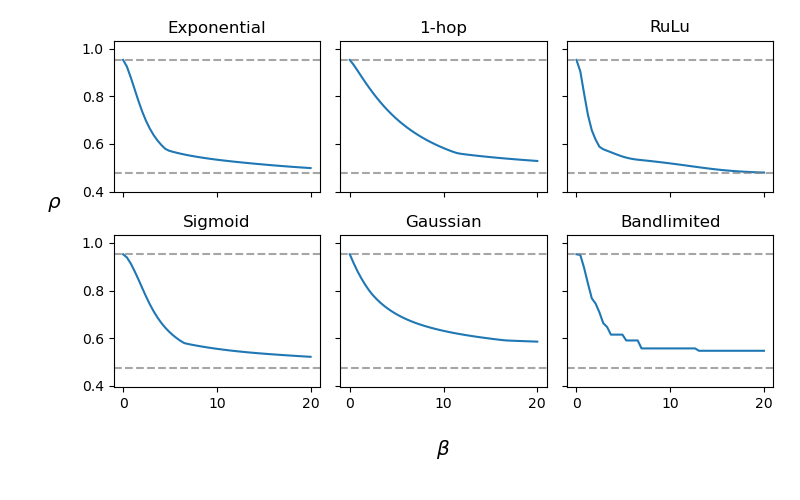

In [9]:
def make_rho_beta_plot():

    gs = {'Exponential': lambda lt, ln, b: np.exp(-b * (ln + lt)), 
        '1-hop': lambda lt, ln, b: (1 + b * (ln + lt)) ** -1, 
        'RuLu': lambda lt, ln, b: np.maximum(1 - b * (ln + lt), 0), 
        'Sigmoid': lambda lt, ln, b: 2 * (1 + np.exp(b * (lt + ln))) ** -1, 
        'Gaussian': lambda lt, ln, b: np.exp(-(b * (ln + lt) ** 2)),
        'Bandlimited': lambda lt, ln, b: ((b * (lt + ln)) <= 1).astype(float)}

    betas = np.linspace(0, 20)

    fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(8, 5))
    
    N = 16
    T = 16

    gamma = 0.05

    Y, S, LN, LT = dummy_data(N, T, m=0.5)

    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    U = np.kron(UT, UN)
    S_ = 1 - S
    DS_ = np.diag(vec(S_))

    vmax = 1 / (1 + gamma)
    vmin = vmax * S_.sum() / (N * T)

    for fil, ax in zip(gs.keys(), axes.ravel()):
        
        g = gs[fil]
        rhos = []

        for beta in betas:

            G = g(lamN[:, None], lamT[None, :], beta)
            J = G ** 2 / (G ** 2 + gamma)
            DJ = np.diag(vec(J))

            rhos.append(np.linalg.eigvals(U @ DJ @ U.T @ DS_).max())

        ax.plot(betas, rhos)
        ax.axhline(vmax, ls='--', color='gray', alpha=0.7)
        ax.axhline(vmin, ls='--', color='gray', alpha=0.7)
        ax.set_title(fil)
        ax.set_ylim(vmin-0.08, vmax+0.08)
        
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r'$\beta$', size='x-large', labelpad=20)
    plt.ylabel(r'$\rho$', rotation=0, labelpad=20, size='x-large')

    plt.tight_layout()

    plt.savefig('beta-rho-plot.pdf')

    # subprocess.run(['pdfcrop', 'beta-rho-plot.pdf', 'beta-rho-plot.pdf'])

make_rho_beta_plot()

/home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


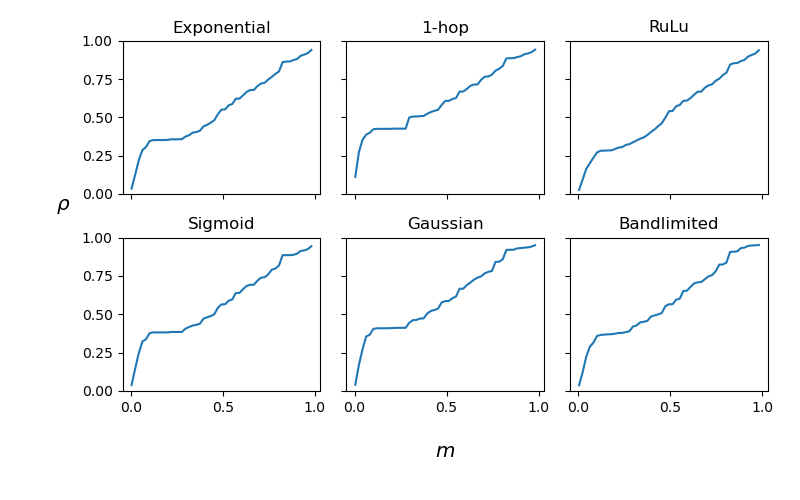

In [10]:
def make_rho_m_plot():

    gs = {'Exponential': lambda lt, ln, b: np.exp(-b * (ln + lt)), 
        '1-hop': lambda lt, ln, b: (1 + b * (ln + lt)) ** -1, 
        'RuLu': lambda lt, ln, b: np.maximum(1 - b * (ln + lt), 0), 
        'Sigmoid': lambda lt, ln, b: 2 * (1 + np.exp(b * (lt + ln))) ** -1, 
        'Gaussian': lambda lt, ln, b: np.exp(-(b * (ln + lt) ** 2)),
        'Bandlimited': lambda lt, ln, b: ((b * (lt + ln)) <= 1).astype(float)}

    ms = (np.arange(1, 256, 5) / 256) + 1e-8

    fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(8, 5))
    
    N = 16
    T = 16

    gamma = 0.05

    Y, S, LN, LT = dummy_data(N, T, m=0.5)

    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    U = np.kron(UT, UN)
    
    si = np.random.permutation(N * T)

    for fil, ax in zip(gs.keys(), axes.ravel()):
        
        g = gs[fil]
        G = g(lamN[:, None], lamT[None, :], 5)
        J = G ** 2 / (G ** 2 + gamma)
        DJ = np.diag(vec(J))
        
        rhos = []

        for m in ms:

            S = np.ones(N * T)
            S[si[:int(N * T * m)]] = 0
            
            DS_ = np.diag(1 - S)

            rhos.append(np.linalg.eigvals(U @ DJ @ U.T @ DS_).max())

        ax.plot(ms, rhos)
        ax.set_title(fil)

        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_ylim(0, 1)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r"$m$", size='x-large', labelpad=20)
    plt.ylabel(r'$\rho$', rotation=0, labelpad=20, size='x-large')

    plt.tight_layout()

    plt.savefig('m-rho-plot.pdf')

    # subprocess.run(['pdfcrop', 'm-rho-plot.pdf', 'm-rho-plot.pdf'])

make_rho_m_plot()


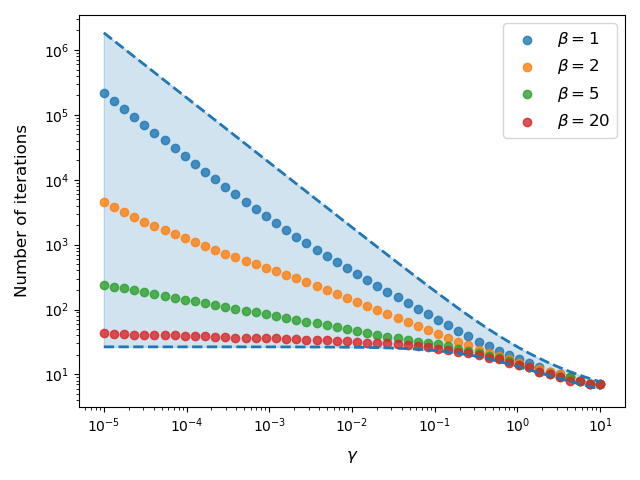

In [463]:
def make_it_gamma_plot():

    gs = np.logspace(-5, 1)

    plt.figure()

    ep = 1e-8

    m = 0.5

    y1 = -np.log(ep) / np.log(1 + gs)
    y2 = -np.log(ep) / (np.log(1 + gs) - np.log(m))

    plt.plot(gs, y1, color='tab:blue', ls='--', lw=2)
    plt.plot(gs, y2, color='tab:blue', ls='--', lw=2)
    plt.fill_between(gs, y1, y2, alpha=0.2,  color='tab:blue')

    N = 16
    T = 16

    Y, S, LN, LT = dummy_data(N, T, m=0.5)
    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)
    U = np.kron(UT, UN)

    S_ = 1 - S
    DS_ = np.diag(vec(S_))

    betas = [1, 2, 5, 20]

    its = {beta: [] for beta in betas}

    for beta in betas:

        for gamma in gs:

            G = g(lamN[:, None], lamT[None, :], beta, beta)
            J = G ** 2 / (G ** 2 + gamma)
            DJ = np.diag(vec(J))
            lamV, V = np.linalg.eig(U @ DJ @ U.T @ DS_)

            E = mat(DS_ @ V[:, np.argmax(lamV)], (N, T))

            E /= np.linalg.norm(vec(E))

            i = 0
            while (E ** 2).sum() ** 0.5 > ep:

                E = UN @ (J * (UN.T @ (S_ * E) @ UT)) @ UT.T
                i += 1
            
            its[beta].append(i)

        plt.scatter(gs, its[beta], label=r'$\beta = ' + str(beta) + '$', alpha=0.8)
            

    plt.legend(fontsize='large')
    plt.xlabel(r'$\gamma$', size='large', labelpad=10)
    plt.ylabel('Number of iterations', size='large', labelpad=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()

    # plt.savefig('it_gamma_plot.pdf')

make_it_gamma_plot()

[-158.114 -137.324 -119.268 -103.585  -89.965  -78.136  -67.862  -58.939  -51.19   -44.459  -38.613  -33.536  -29.127  -25.298  -21.972  -19.083  -16.575  -14.396  -12.504  -10.861   -9.434   -8.195   -7.118   -6.184   -5.373   -4.669   -4.057   -3.527   -3.066   -2.667   -2.321   -2.02    -1.76    -1.535   -1.341   -1.173   -1.028   -0.903   -0.796   -0.703   -0.624   -0.557   -0.499   -0.449   -0.407   -0.37    -0.339   -0.312   -0.288   -0.268]


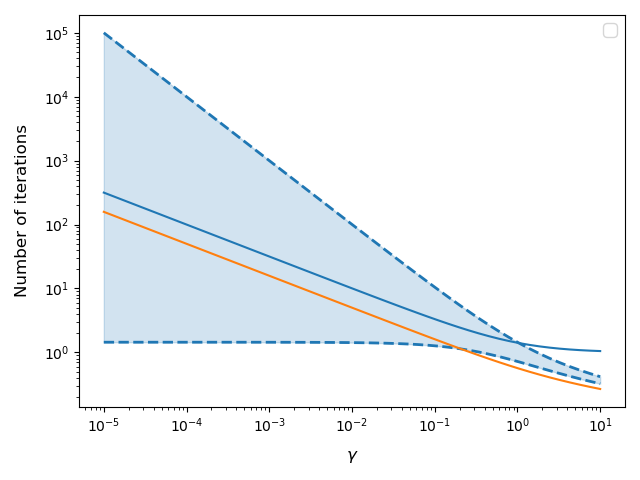

In [15]:

gs = np.logspace(-5, 1)

plt.figure()

ep = 1e-8

m = 0.5

y1 = 1 / np.log(1 + gs)
y2 = 1 / (np.log(1 + gs) - np.log(m))

plt.plot(gs, y1, color='tab:blue', ls='--', lw=2)
plt.plot(gs, y2, color='tab:blue', ls='--', lw=2)
plt.fill_between(gs, y1, y2, alpha=0.2,  color='tab:blue')

rK = rK = (1 / gs + 1) ** 0.5

plt.plot(gs, rK)

print(1 / np.log((rK - 1) / (rK + 1)))
plt.plot(gs, - 1 / np.log((rK - 1) / (rK + 1)))

plt.legend(fontsize='large')
plt.xlabel(r'$\gamma$', size='large', labelpad=10)
plt.ylabel('Number of iterations', size='large', labelpad=10)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()



In [30]:
def get_its(N, T):

    np.random.seed(0)

    gs = np.logspace(-5, 1)

    Y, S, LN, LT = dummy_data(N, T, m=0.5)
    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)
    U = np.kron(UT, UN)

    S_ = 1 - S
    DS_ = np.diag(vec(S_))

    betas = [1, 2, 5, 20]

    its_cgm = {beta: [] for beta in betas}
    its_sim = {beta: [] for beta in betas}

    for beta in betas:

        for gamma in gs:

            Y_sim, i_sim = SIM(Y, S, LN, LT, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': UN, 'UT': UT, 'lamN': lamN, 'lamT': lamT})
            Y_cgm, i_cgm = CGM(Y, S, LN, LT, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': UN, 'UT': UT, 'lamN': lamN, 'lamT': lamT})

            its_sim[beta].append(i_sim)
            its_cgm[beta].append(i_cgm)

    return its_sim, its_cgm






In [31]:
its_sim, its_cgm = get_its(50, 50)

In [36]:
def make_it_gamma_plot2(its_sim, its_cgm):

    gs = np.logspace(-5, 1)

    fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

    for beta in [1, 2, 5, 20]:

        axes[0].plot(gs, its_sim[beta], label=r'$\beta = ' + str(beta) + '$', alpha=0.9)
        axes[1].plot(gs, its_cgm[beta], label=r'$\beta = ' + str(beta) + '$', alpha=0.9)

    for ax in axes:
        ax.set_xscale('log')
        ax.set_yscale('log')

    axes[0].set_title('SIM')
    axes[1].set_title('CMG')


    plt.legend()
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r"$\gamma$", size='x-large', labelpad=20)
    plt.ylabel(r'Number of iterations', labelpad=20, size='x-large')

    plt.tight_layout()

    plt.savefig('experimental_its_for_conv.pdf')


    subprocess.run(['pdfcrop', 'experimental_its_for_conv.pdf', 'experimental_its_for_conv.pdf'])



PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `experimental_its_for_conv.pdf'.


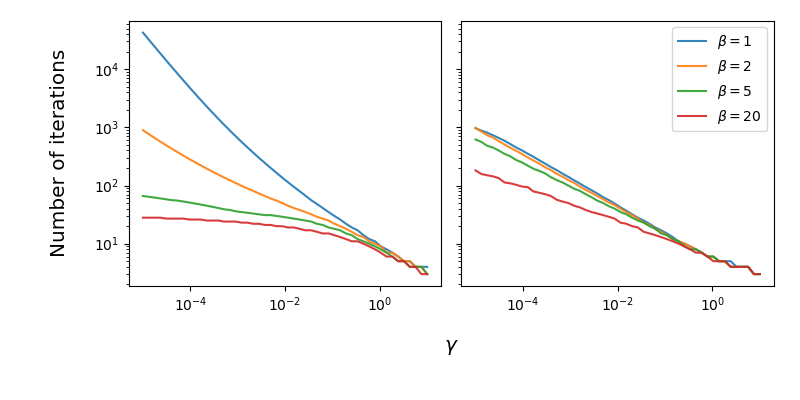

In [37]:
make_it_gamma_plot2(its_sim, its_cgm)

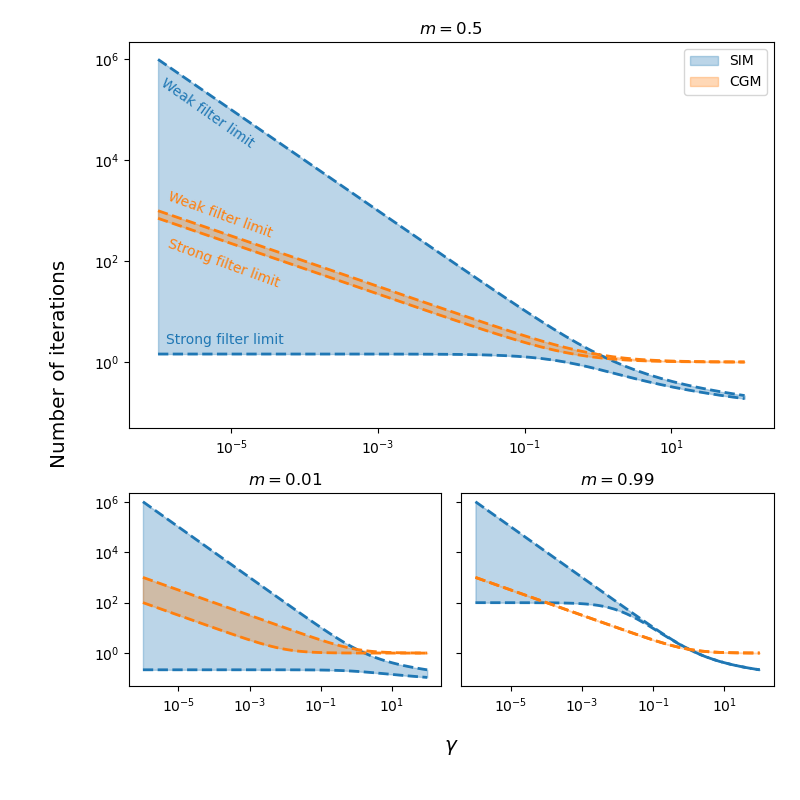

In [536]:
def make_it_gamma_plot_CGM():

    gs = np.logspace(-6, 2)

    fig, axes = plt.subplot_mosaic("AA;BC", sharey=True, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

    y1 = (1 / gs + 1) ** 0.5
    ya = 1 / np.log(1 + gs)
    

    for ax, m in zip(axes.values(), [0.5, 0.01, 0.99]):
        
        y2 = (m / gs + 1) ** 0.5
        yb = 1 / (np.log(1 + gs) - np.log(m))

        ax.plot(gs, ya, color='tab:blue', ls='--', lw=2)
        ax.plot(gs, yb, color='tab:blue', ls='--', lw=2)
        ax.fill_between(gs, ya, yb, alpha=0.3,  color='tab:blue', label='SIM')

        ax.plot(gs, y1, color='tab:orange', ls='--', lw=2)
        ax.plot(gs, y2, color='tab:orange', ls='--', lw=2)
        ax.fill_between(gs, y1, y2, alpha=0.3, color='tab:orange', label='CGM')

        ax.set_xscale('log')
        ax.set_yscale('log')


    axes['A'].set_title(r'$m=0.5$')
    axes['B'].set_title(r'$m=0.01$')
    axes['C'].set_title(r'$m=0.99$')

    axes['A'].legend()

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r"$\gamma$", size='x-large', labelpad=20)
    plt.ylabel(r'Number of iterations', labelpad=20, size='x-large')


    axes['A'].text(1e-6, 18e3, 'Weak filter limit', color='tab:blue', rotation=-35)
    axes['A'].text(1.3e-6, 2.3e0, 'Strong filter limit', color='tab:blue')

    axes['A'].text(1.3e-6, 3e2, 'Weak filter limit', color='tab:orange', rotation=-20)
    axes['A'].text(1.3e-6, 3e1, 'Strong filter limit', color='tab:orange', rotation=-20)

    plt.tight_layout()
    plt.savefig('conv_SIM_CGM_compared.pdf')


make_it_gamma_plot_CGM()

In [367]:
N = 16
T = 16

Y, S, LN, LT = dummy_data(N, T, m=0.5)
lamN, UN = np.linalg.eigh(LN)
lamT, UT = np.linalg.eigh(LT)
U = np.kron(UT, UN)

S_ = 1 - S
DS_ = np.diag(vec(S_))

G = g(lamN[:, None], lamT[None, :], 1000, 1000)
J = G ** 2 / (G ** 2 + 1)
DJ = np.diag(vec(J))
lamV, V = np.linalg.eig(U @ DJ @ U.T @ DS_)

E = mat(V[:, np.argmax(lamV)], (N, T))

E = UN @ (J * (UN.T @ (S_ * E) @ UT)) @ UT.T


In [235]:
from scipy.optimize import minimize

In [306]:
k = 6

def f(e):

    E = mat(e, (N , T))

    for i in range(k):

        E = UN @ (J * (UN.T @ (S_ * E) @ UT)) @ UT.T

    return -(E ** 2).sum()


x0 = np.random.normal(size=N*T)
x0 /= np.linalg.norm(x0)

out = minimize(f, constraints=({'type': 'eq', 'fun': lambda x: (x ** 2).sum() - 1}), x0=x0)

out.x

array([ 0.015, -0.151, -0.067,  0.02 ,  0.042,  0.021,  0.014, -0.097,  0.01 , -0.015, -0.065,  0.001,  0.105,  0.006, -0.02 , -0.054,  0.092, -0.014,  0.051,  0.109, -0.001,  0.02 , -0.016,  0.04 , -0.122, -0.088,  0.044,  0.01 ,  0.039,  0.032,  0.006, -0.007, -0.008,  0.003, -0.105, -0.058, -0.02 , -0.041, -0.044, -0.001,  0.038,  0.046,  0.037,  0.054, -0.03 ,  0.051,  0.085, -0.019,  0.069, -0.044,  0.034, -0.099, -0.02 , -0.063,  0.013,  0.022,  0.127, -0.037,  0.029,  0.114,  0.062,
        0.091, -0.043,  0.02 , -0.004,  0.104, -0.037, -0.062,  0.026,  0.007, -0.002,  0.142, -0.066, -0.025,  0.035, -0.027, -0.046, -0.082, -0.002,  0.049,  0.076,  0.021,  0.007, -0.074,  0.006, -0.059,  0.07 ,  0.144,  0.064, -0.025,  0.068, -0.049,  0.087, -0.015,  0.036,  0.033,  0.069,  0.051,  0.046,  0.051, -0.08 , -0.029, -0.031,  0.036, -0.015,  0.067,  0.013,  0.04 ,  0.175,  0.043, -0.072,  0.007, -0.064,  0.034,  0.015, -0.073,  0.037, -0.012,  0.041, -0.013, -0.018,  0.018,
       -0.

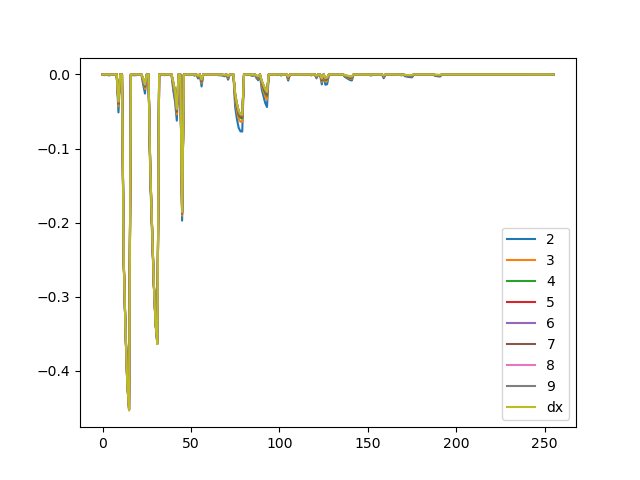

In [343]:
A = U @ DJ @ U.T @ DS_

lamV, V = np.linalg.eig(A)

plt.figure()

for i in range(10):

    AA = np.linalg.matrix_power(A, i)

    xx = np.linalg.eigh(AA.T @ AA)[1][:, -1]

    if xx[1] > 0:
        xx *= -1

    if i > 1:
        plt.plot(xx, label=i)

xx = DS_ @ V[:, np.argmax(lamV)]
xx /= np.linalg.norm(xx)

plt.plot(xx, label='dx')

plt.legend()

In [359]:
np.diag(np.array([1] + [0] * (N * T - 1))) @ U.T

array([[0.063, 0.063, 0.063, 0.063, 0.063, ..., 0.062, 0.062, 0.062, 0.062, 0.062],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   , 0.   , 0.   ]])

In [328]:
AA = np.linalg.matrix_power(A, 3)

1000 * AA.T @ AA

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.115,  0.   ,  0.077,  0.051, ...,  0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.077,  0.   ,  0.055,  0.038, ...,  0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [ 0.   ,  0.051,  0.   ,  0.038,  0.027, ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.02 ,  0.   ,  0.   ,  0.018,  0.019],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.   , ...,  0.018,  0.   ,  0.   ,  0.05 ,  0.057],
       [ 0.   , -0.   ,  0.   , -0.   ,  0.   , ...,  0.019,  0.   ,  0.   ,  0.057,  0.067]])

In [329]:
K = DS_ @ np.linalg.matrix_power(A, 2) @ U


1000 * K @ DJ ** 2 @ K.T

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.115,  0.   ,  0.077,  0.051, ...,  0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.077,  0.   ,  0.055,  0.038, ...,  0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [ 0.   ,  0.051,  0.   ,  0.038,  0.027, ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.02 ,  0.   ,  0.   ,  0.018,  0.019],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.   , ...,  0.018,  0.   ,  0.   ,  0.05 ,  0.057],
       [ 0.   , -0.   ,  0.   , -0.   ,  0.   , ...,  0.019,  0.   ,  0.   ,  0.057,  0.067]])

In [331]:
np.linalg.eigh(1000 * K @ DJ ** 2 @ K.T)[1]

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.053, -0.101,  0.332, -0.066,  0.   ],
       [-0.002,  0.036, -0.019,  0.041, -0.177, ..., -0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [-0.002,  0.014,  0.057, -0.035,  0.1  , ...,  0.034, -0.066,  0.226, -0.045,  0.   ],
       [-0.001,  0.009, -0.049,  0.021, -0.071, ...,  0.022, -0.043,  0.151, -0.031,  0.001],
       ...,
       [-0.001,  0.002, -0.003, -0.003, -0.002, ..., -0.054, -0.088, -0.006, -0.008,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.001,  0.001, -0.004, -0.001, -0.003, ..., -0.11 , -0.06 , -0.001, -0.002,  0.   ],
       [ 0.   , -0.001,  0.004,  0.001,  0.002, ..., -0.124, -0.063, -0.001, -0.001,  0.   ]])

In [332]:
K

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.006, -0.008,  0.006, -0.003,  0.001, ..., -0.   , -0.   , -0.   ,  0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.005, -0.006,  0.003, -0.   , -0.002, ..., -0.   , -0.   , -0.   ,  0.001, -0.   ],
       [ 0.004, -0.004,  0.001,  0.001, -0.002, ...,  0.   , -0.   , -0.   ,  0.   , -0.   ],
       ...,
       [ 0.003,  0.002, -0.002, -0.002, -0.   , ..., -0.   ,  0.   , -0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.004,  0.005,  0.004,  0.002,  0.002, ...,  0.   ,  0.   , -0.   ,  0.   ,  0.   ],
       [ 0.004,  0.005,  0.004,  0.003,  0.002, ...,  0.   , -0.   ,  0.   ,  0.   ,  0.   ]])

In [298]:
A = U @ DJ @ U.T @ DS_

AA = np.linalg.matrix_power(A, k)

xx = np.linalg.eigh(AA.T @ AA)[1][:, -1]

xx

array([ 0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.038,  0.   ,  0.   , -0.253, -0.347, -0.417, -0.452, -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.007, -0.015,  0.   ,  0.   , -0.129, -0.207, -0.283, -0.337, -0.363, -0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.011, -0.024, -0.048,  0.   ,  0.   , -0.187,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   , -0.001,  0.   , -0.002,  0.   , -0.008,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   , -0.001, -0.001,  0.   , -0.003,  0.   ,  0.   ,  0.   , -0.028, -0.041, -0.051, -0.055, -0.056, -0.   ,  0.   , -0.   ,  0.   , -0.   , -0.001,  0.   , -0.002, -0.003,  0.   , -0.01 , -0.016, -0.022, -0.025,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.001,  0.   ,  0.   ,  0.   , -0.004,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   , -0.002,
        0.

In [287]:
U @ DJ @ U.T @ DS_

array([[ 0.   ,  0.074,  0.   ,  0.014,  0.003, ...,  0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [ 0.   ,  0.067,  0.   ,  0.028,  0.011, ...,  0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [ 0.   ,  0.049,  0.   ,  0.046,  0.027, ...,  0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [ 0.   ,  0.028,  0.   ,  0.055,  0.046, ...,  0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [ 0.   ,  0.011,  0.   ,  0.046,  0.055, ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.055,  0.   ,  0.   ,  0.011,  0.003],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , ...,  0.046,  0.   ,  0.   ,  0.028,  0.014],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.   , ...,  0.027,  0.   ,  0.   ,  0.049,  0.039],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.   , ...,  0.011,  0.   ,  0.   ,  0.067,  0.074],
       [ 0.   , -0.   ,  0.   , -0.   ,  0.   , ...,  0.003,  0.   ,  0.   ,  0.074,  0.102]])

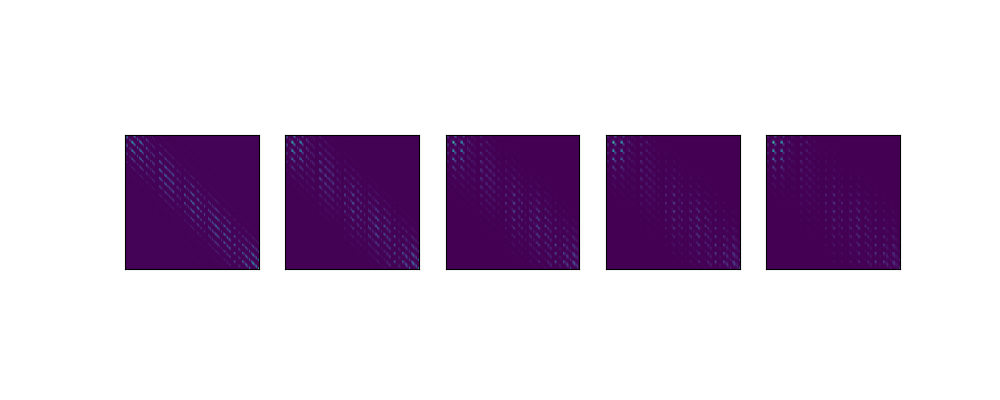

In [289]:
fig, ax = plt.subplots(ncols=5, figsize=(10, 4), sharex=True, sharey=True)

for i in range(5):
    ax[i].imshow(np.linalg.matrix_power(A, i+1)) 

    ax[i].set_xticks([])
    ax[i].set_yticks([])



In [291]:
f(out.x)

-4.1622571174226476e-06

In [292]:
f(xx)

-0.00018667435858232863

In [53]:
nts = np.sort(np.array(list(set(np.sort(np.concatenate([np.logspace(1, 4).astype(int), np.linspace(1e1, 1e4).astype(int)])).tolist()))))


def get_ts():

    ts = [[], [], [], [], []]

    active = [True, True, True, True, True]

    g_ = lambda lamN, lamT: g(lamN, lamT, 0.5, 0.5)
    gamma = 1

    for nt in tqdm(nts):
        
        if not any(active):
            break

        Y, S, LN, LT = dummy_data(nt, nt)

        all_args = [(Y, S, LN, LT, gamma, g_), (Y, S, LN, LT, gamma, g_), (Y, S, LN, LT, gamma, g_), (Y, S, gamma, g_), (Y, S, gamma, g_)]

        for i, (solver, args) in enumerate(zip([direct, SIM, CGM, SIM_grid, CGM_grid], all_args)):

            if active[i]:

                t0 = time.time()
                solver(*args)
                t = time.time() - t0

                ts[i].append(t)
            
                if t > 60:
                    active[i] = False

        print(nt, np.array([ts[i][-1] for i in range(5)]))

    return ts

In [54]:
ts = get_ts()

  0%|          | 0/97 [00:00<?, ?it/s]

10 [0.002 0.001 0.001 0.001 0.001]
11 [0.004 0.    0.001 0.001 0.002]
13 [0.002 0.001 0.001 0.001 0.002]
15 [0.01  0.001 0.001 0.001 0.001]
17 [0.008 0.001 0.001 0.002 0.002]
20 [0.011 0.001 0.001 0.001 0.002]
23 [0.024 0.001 0.001 0.002 0.003]
26 [0.036 0.001 0.001 0.001 0.002]
30 [0.094 0.001 0.002 0.002 0.002]
35 [0.179 0.001 0.002 0.002 0.002]
40 [0.337 0.001 0.001 0.002 0.002]
47 [0.801 0.001 0.001 0.003 0.003]
54 [1.167 0.001 0.002 0.002 0.002]
62 [2.968 0.001 0.002 0.002 0.003]
71 [5.102 0.002 0.003 0.006 0.006]
82 [11.701  0.002  0.002  0.004  0.006]
95 [28.248  0.002  0.003  0.004  0.004]
109 [62.089  0.003  0.004  0.017  0.017]
126 [62.089  0.005  0.005  0.005  0.006]
145 [62.089  0.005  0.006  0.009  0.014]
167 [62.089  0.008  0.008  0.059  0.059]
193 [62.089  0.011  0.016  0.094  0.086]
213 [62.089  0.013  0.017  0.026  0.031]
222 [62.089  0.012  0.017  0.018  0.021]
255 [62.089  0.021  0.028  0.023  0.032]
294 [62.089  0.027  0.036  0.026  0.035]
339 [62.089  0.045  0.063 

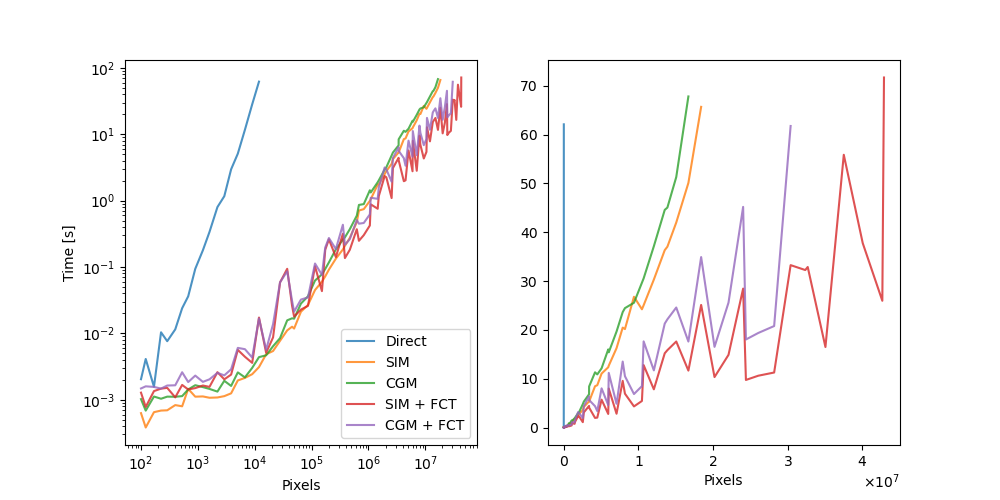

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

for t, label in zip(ts, ['Direct', 'SIM', 'CGM', 'SIM + FCT', 'CGM + FCT']):

    ax[0].plot(nts[:len(t)] ** 2, t, label=label, alpha=0.8)
    ax[1].plot(nts[:len(t)] ** 2, t, label=label, alpha=0.8)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel('Pixels')
ax[1].set_xlabel('Pixels')
ax[0].set_ylabel('Time [s]')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)

ax[0].legend()

plt.savefig('SIM_CGM_time.pdf')

In [39]:

def plot_gamma():

    gammas = np.logspace(-6, 1)

    its_sim = []
    its_cgm = []

    Y, S, LN, LT = dummy_data(50, 50)

    g_ = lambda lamN, lamT: g(lamN, lamT, 0.5, 0.5)

    for gamma in tqdm(list(reversed(gammas))):

        F_sim, it_sim = SIM(Y, S, LN, LT, gamma, g_)
        F_cgm, it_cgm = CGM(Y, S, LN, LT, gamma, g_)

        its_sim.append(it_sim)
        its_cgm.append(it_cgm)

    plt.figure()

    plt.scatter(gammas, list(reversed(its_cgm)), label='CGM', alpha=0.8)
    plt.scatter(gammas, list(reversed(its_sim)), label='SIM', alpha=0.8)

    plt.plot(gammas, 5 * ((1 + gammas) / gammas) ** 0.5, ls='--', label='CGM - theoretical upper bound', alpha=0.8)
    plt.plot(gammas, 10 / np.log(1 + gammas), ls='--', label='SIM - theoretical upper bound', alpha=0.8)


    plt.xscale('log')
    plt.yscale('log')

    plt.legend()

    plt.xlabel('$\gamma$')
    plt.ylabel('Iteration count')

In [40]:
gamma = 0.1

betas = np.linspace(0.1, 2.1, 21)

its_sim = []
its_cgm = []

Y, S, LN, LT = dummy_data(50, 50)


for beta in tqdm(betas):

    g_ = lambda lamN, lamT: g(lamN, lamT, beta, beta)

    F_sim, it_sim = SIM(Y, S, LN, LT, gamma, g_)
    F_cgm, it_cgm = CGM(Y, S, LN, LT, gamma, g_)

    its_sim.append(it_sim)
    its_cgm.append(it_cgm)

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0, 0.5, 'Iteration count')

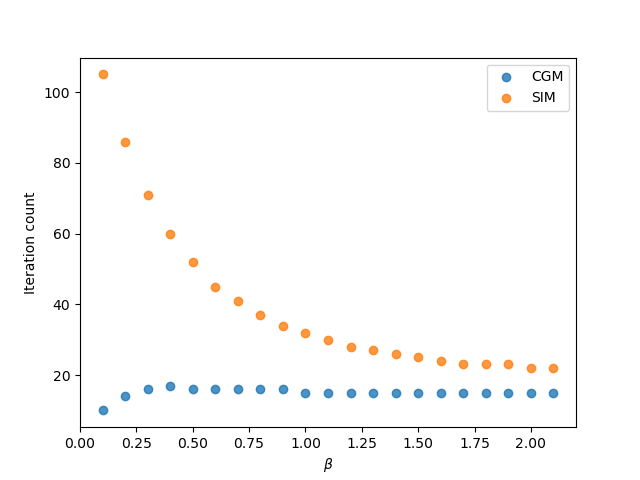

In [43]:
plt.figure()

plt.scatter(betas, its_cgm, label='CGM', alpha=0.8)
plt.scatter(betas, its_sim, label='SIM', alpha=0.8)


# plt.xscale('log')
# plt.yscale('log')

plt.legend()

plt.xlabel(r'$\beta$')
plt.ylabel('Iteration count')

In [47]:
gamma = 0.1

betas = np.linspace(0.1, 2.1, 21)

j_max = []
j_min = []

N = 50
T = 50

Y, S, LN, LT = dummy_data(N, T)

lamN = 2 - 2 * np.cos(N ** -1 * np.pi * np.arange(N))
lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

UT = np.cos( np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)) / T)
UT /= np.linalg.norm(UT, axis=0)


UN = np.cos( np.pi * np.outer(np.arange(N) + 0.5, np.arange(N)) / N)
UN /= np.linalg.norm(UN, axis=0)


for beta in tqdm(betas):

    g_ = lambda lamN, lamT: g(lamN, lamT, beta, beta)

    G2 = g_(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    Mi = np.kron(UT, UN) @ np.diag(vec(J)) @ np.kron(UT.T, UN.T)

    MM = Mi @ np.diag(vec(1 - S))

    lam = np.linalg.eigvals(MM)

    j_max.append(lam.max())
    j_min.append(lam.min())

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0, 0.5, 'Iteration count')

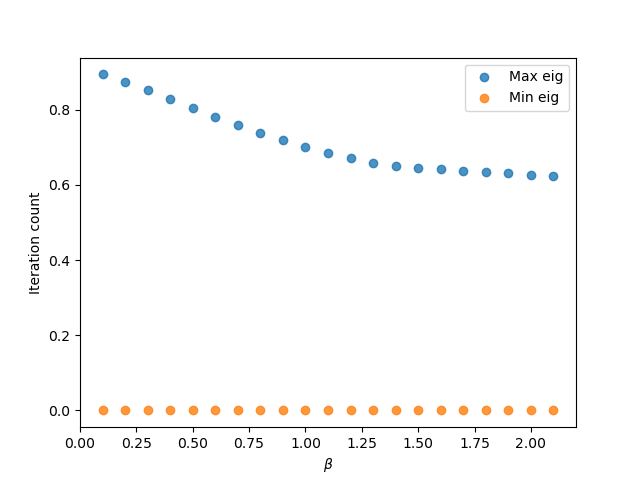

In [49]:
plt.figure()

plt.scatter(betas, j_max, label='Max eig', alpha=0.8)
plt.scatter(betas, j_min, label='Min eig', alpha=0.8)
plt.scatter(betas, )


# plt.xscale('log')
# plt.yscale('log')

plt.legend()

plt.xlabel(r'$\beta$')
plt.ylabel('Iteration count')

In [31]:
def rho(A):
    return np.linalg.eigvals(A).max()

def kappa(A):
    eigs = np.linalg.eigvals(A)
    return eigs.max() / eigs.min()

N = 5
T = 6

gamma = 1

Y, S, LN, LT = dummy_data(N, T, 0.5)

lamN, UN = np.linalg.eigh(LN)
lamT, UT = np.linalg.eigh(LT)

U = np.kron(UT, UN)
G = g(lamN[:, None], lamT[None, :], 1000, 1000)
DG = np.diag(vec(G))
J = G ** 2 / (G ** 2 + gamma)
DJ = np.diag(vec(J))
DS = np.diag(vec(S))
DS_ = np.diag(vec(1 - S))

In [71]:
rho( )

array([-0.   ,  0.382,  1.382,  2.618,  3.618])

In [32]:
rho(U @ DJ @ U.T @ DS_)

0.24999999999995276

In [34]:
np.linalg.norm(U @ DJ @ U.T @ DS_, ord=2)

0.35355339059320684

In [10]:
(1 - S).sum() / ((N * T) * (1 + gamma))

0.23333333333333334

In [11]:
kappa(DG @ U.T @ DS @ U @ DG + gamma * np.eye(N *T))

1.533333333333132

In [12]:
(S.sum() / (N * T) + gamma) / gamma

1.5333333333333332

In [13]:
G = g(lamN[:, None], lamT[None, :], 0, 0)
DG = np.diag(vec(G))
J = G ** 2 / (G ** 2 + gamma)
DJ = np.diag(vec(J))

In [14]:
rho(U @ DJ @ U.T @ DS_)

0.5000000000000004

In [15]:
1 / (1 + gamma)

0.5

In [17]:
kappa(DG @ U.T @ DS @ U @ DG + gamma * np.eye(N *T))

(2.0000000000000044+0j)

In [16]:
(1 + gamma) / gamma


2.0

In [344]:
G = g(lamN[:, None], lamT[None, :], 0.5, 0.5)
DG = np.diag(vec(G))
J = G ** 2 / (G ** 2 + gamma)
DJ = np.diag(vec(J))

A = U @ DJ @ U.T @ DS_

0.44999999999999996


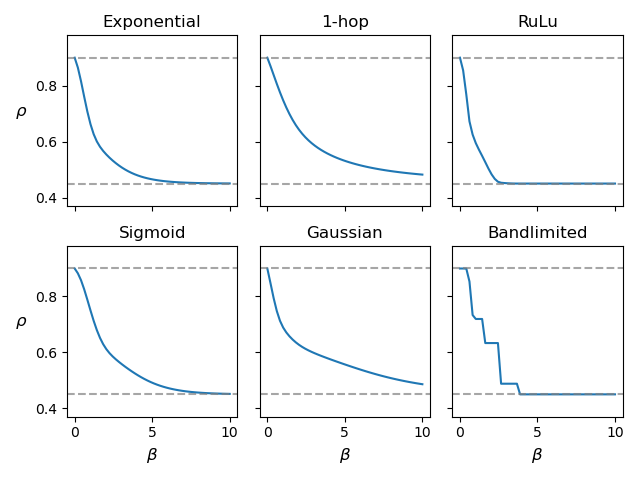

In [98]:
make_sim_rho_plot()

/tmp/ipykernel_12020/1158170460.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


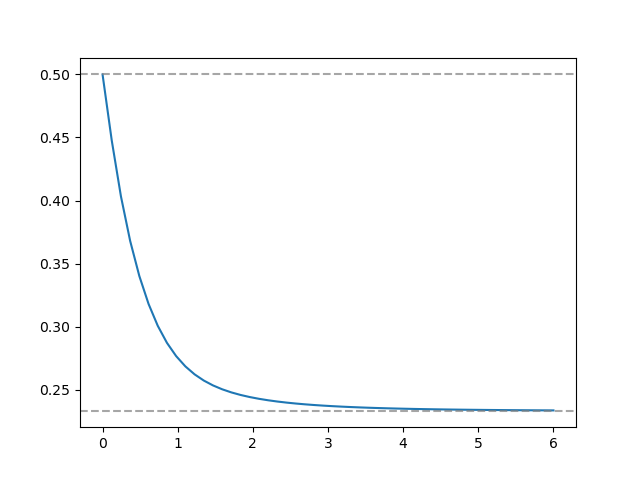

In [46]:
plt.figure()





plt.plot(betas, rhos)
# plt.plot(betas,  (vmin + (vmax - vmin) * np.exp(-1.8 * betas)))

plt.axhline(vmax, ls='--', color='gray', alpha=0.7)
plt.axhline(vmin, ls='--', color='gray', alpha=0.7)

In [28]:
DS.sum() / (N * T)

0.5333333333333333